# Switchiness- Methylation

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/DX/Notebooks


importing IPython notebook from metaPCNA

importing IPython notebook from Imports

0.922514619883


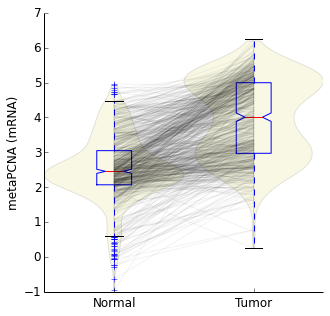

In [2]:
import NotebookImport
from metaPCNA import *

In [3]:
import MethylTools.Probe_Annotations as DX

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

In [4]:
import seaborn as sns
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

#### Generate probe-level coorelation with meta-PCNA 
* This takes a while, I'm doing it in chunks

In [5]:
store = '/data_ssd/TCGA_methylation_2014_04_16.h5'
matched_meth = pd.read_hdf(store, 'matched_tn')
matched_meth = matched_meth.groupby(axis=1, level=[0,1]).first()

In [6]:
dp = -1*meta_pcna_all.unstack()[['01','11']].dropna().T.diff().ix['11']
dp = dp[dp > 0]
dp.name = 'proliferation change'
dx = matched_meth
dx = dx.xs('01',1,1) - dx.xs('11',1,1)

pcna_corr = dx.T.corrwith(dp)

In [7]:
dx_meth = binomial_test_screen(matched_meth, fc=1.)
dx_meth = dx_meth[dx_meth.num_dx > 300]

In [8]:
spearman_pandas(pcna_corr, dx_meth.frac)

rho    0.53
p      0.00
dtype: float64

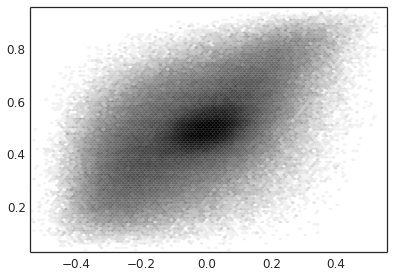

In [9]:
a,b = match_series(pcna_corr, dx_meth.frac)
plt.hexbin(a,b, bins='log')

In [10]:
dx_meth.frac.order().tail()

Hybridization REF
cg11411203           0.95
cg15174623           0.95
cg12052661           0.95
cg12597389           0.96
cg06570224           0.97
Name: frac, dtype: float64

In [11]:
m = pd.rolling_mean(dx_meth.frac.ix[pcna_corr.order().index].dropna(), 
                    window=500, center=True).dropna()
m2 = pd.rolling_mean(dx_meth.frac.ix[pcna_corr.order().index].dropna(), 
                    window=50, center=True).dropna()
m = m.combine_first(m2)
f_win = (dx_meth.frac - m).dropna()

In [12]:
m = pd.rolling_mean(pcna_corr.ix[dx_meth.frac.order().index].dropna(), 
                    window=500, center=True).dropna()
m2 = pd.rolling_mean(pcna_corr.ix[dx_meth.frac.order().index].dropna(), 
                    window=50, center=True).dropna()
m = m.combine_first(m2)
pcna_win = (pcna_corr - m).dropna()

In [13]:
def meth_plot(probes=None):
    fig, axs= subplots(1,4, figsize=(20,3))
    for i,v in enumerate([dx_meth.frac, pcna_corr, f_win, pcna_win]):
        if probes is not None:
            v = v.ix[probes]
        ax=axs[i]
        lw = 2.5
        draw_dist(v.ix[ti(DX.probe_sets['Promoter'] & v)], ax=ax, lw=lw)
        draw_dist(v.ix[ti(DX.probe_sets['CpG Island'] & v)], ax=ax, lw=lw)
        draw_dist(v.ix[ti(DX.probe_sets['PRC2'] & v)], ax=ax, lw=lw)
        draw_dist(v.ix[ti(DX.probe_sets['Gene Body'] & v)], ax=ax, lw=lw)
        #draw_dist(pcna_corr.ix[ti(v)], ax=ax, colors='grey', lw=lw)
        ax.set_yticks([])
        ax.set_ylabel('Density')
        ax.set_xlabel('Fraction with Increased Methylation')
        ax.legend(('Promoter','CpG Island','PRC2','Gene Body', 'All Probes'))
        prettify_ax(ax)

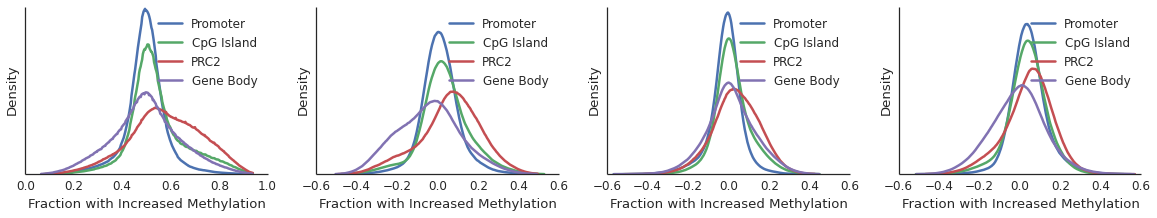

In [14]:
meth_plot()

In [16]:
ann = DX.probe_annotations

In [17]:
dx_g = matched_rna.xs('01',1,1) - matched_rna.xs('11',1,1)

pt = dx.dropna().columns.intersection(dx_g.dropna().columns)
dx2 = dx[pt].astype(float)
dx_g2 = dx_g[pt].astype(float)
a2 = ann.Gene_Symbol.ix[dx2.index].dropna()
rev = pd.Series(a2.index, a2)

In [18]:
dx_g3 = dx_g2.copy()
dx_g3 = dx_g3.ix[rev.index]
dx_g3.index = list(rev)
dx_g3 = dx_g3.dropna()

v1 = dx_g3.T
v2 = dx2.ix[dx_g3.index].T
corr_with_exp = v1.corrwith(v2)

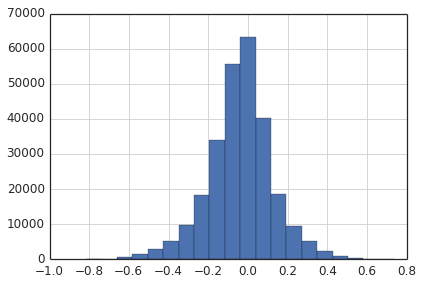

In [19]:
corr_with_exp.hist(bins=20)

In [218]:
mm = matched_meth.xs('11',1,1).mean(1)

In [277]:
fisher_exact_test(mm < .5, dx_meth.frac > .5)

odds_ratio    2.23
p             0.00
dtype: float64

In [278]:
pd.DataFrame({s: fisher_exact_test(mm.ix[ti(v)] < .5, dx_meth.frac > .5)
              for s,v in DX.probe_sets.iteritems()}).T

,odds_ratio,p
CpG Island,1.55,2.86e-141
DHS Site,2.43,0.00e+00
Enhancer,2.67,0.00e+00
Gene Body,1.81,0.00e+00
PRC2,3.98,0.00e+00
Promoter,1.28,1.10e-16
TSS,2.25,0.00e+00


In [279]:
dd = ((dx > 0).T == (mm < .5)).T
entropy = dd.mean()
probe_entropy = dd.mean(1)

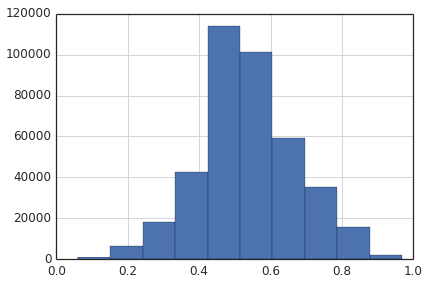

In [291]:
probe_entropy.hist()

In [292]:
def entropy(p):
    '''
    Entropy of a methylaion vector. Here we assume 50% methylation is 
    random and 0 or 1 constitute an informative measument. 
    '''
    q = 1. - p
    s = np.sum((p*np.log(p)) + (q*np.log(q))) / (np.log(.5) * len(p))
    s.name = 'Entropy'
    return s

In [298]:
pat_entropy = entropy(matched_meth)

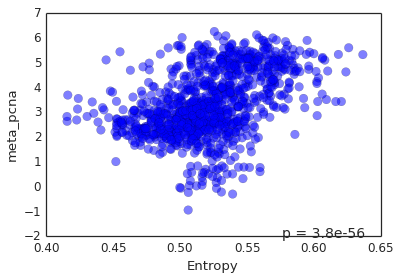

In [311]:
series_scatter(pat_entropy, meta_pcna_all)

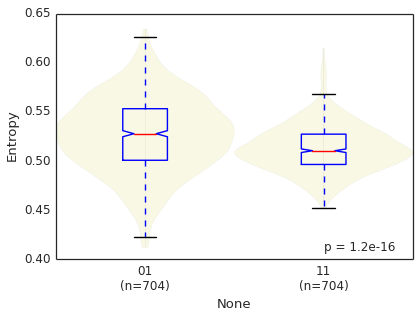

In [300]:
violin_plot_series(pat_entropy)

In [280]:
spearman_pandas(probe_entropy, pcna_corr)

rho   -0.07
p      0.00
dtype: float64

In [281]:
spearman_pandas(entropy, dp)

rho    1.91e-01
p      4.79e-04
dtype: float64

In [282]:
a,b = match_series((mm < .5), (dx_meth.frac > .5))
disordered = a == b
disordered.value_counts()

True     237042
False    159017
dtype: int64

In [236]:
probe_sets = pd.DataFrame(DX.probe_sets)

In [238]:
screen_feature(disordered, fisher_exact_test, probe_sets.T)

,odds_ratio,p,q
PRC2,1.87,0.00e+00,0.00e+00
Promoter,0.54,0.00e+00,0.00e+00
CpG Island,1.25,1.72e-151,4.01e-151
Gene Body,0.84,2.51e-141,4.39e-141
TSS,0.85,4.82e-113,6.75e-113
DHS Site,1.11,9.16e-29,1.07e-28
Enhancer,1.05,7.54e-10,7.54e-10


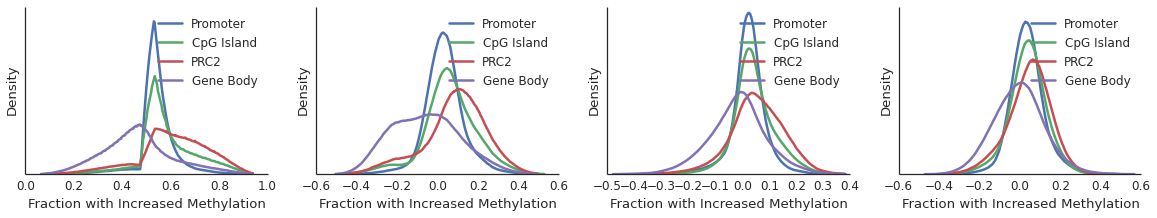

In [283]:
meth_plot(ti(disordered))

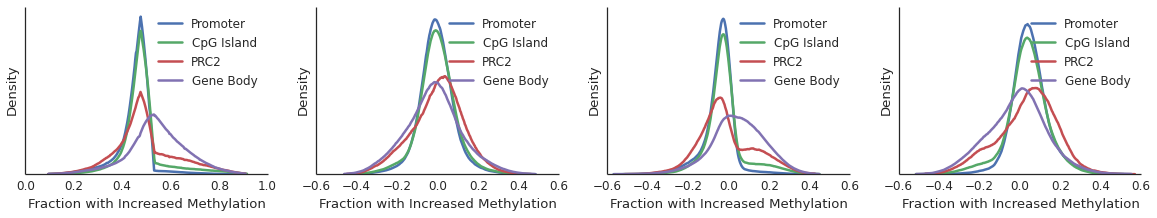

In [284]:
meth_plot(ti(disordered == False))

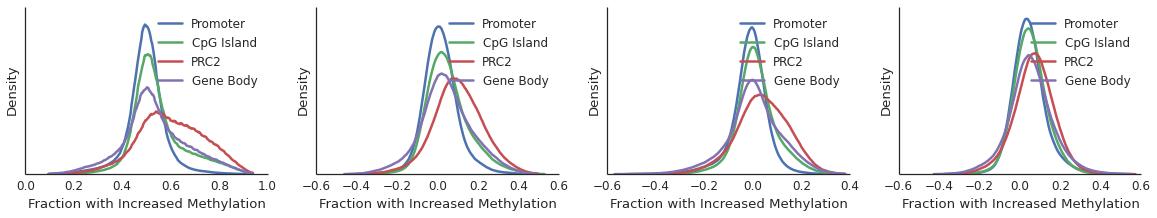

In [285]:
meth_plot(ti(mm < .5))

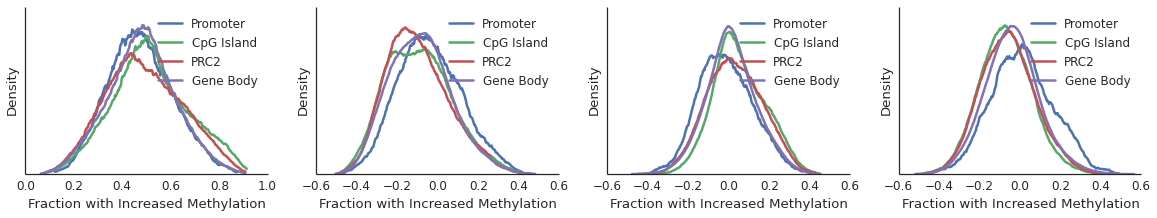

In [286]:
meth_plot(ti(mm > .5))

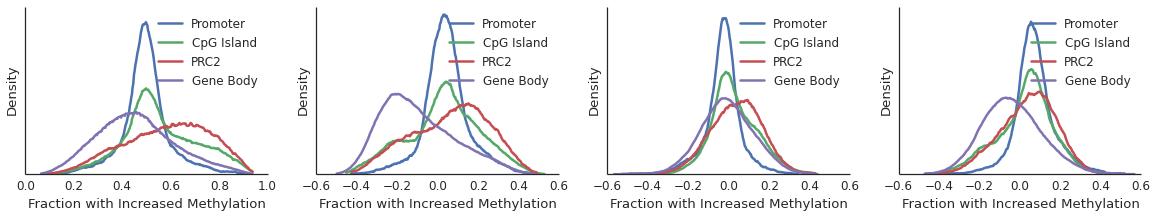

In [287]:
meth_plot(ti(corr_with_exp > .1))

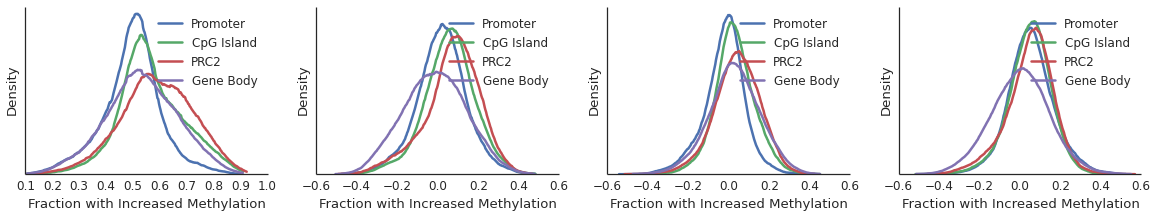

In [288]:
meth_plot(ti(corr_with_exp < -.1))

In [88]:
s = pd.DataFrame({p:pearson_pandas(dx_meth.frac.ix[ti(v)], corr_with_exp) for 
                  p,v in DX.probe_sets.iteritems()}).T
s.sort('p')

,rho,p
Gene Body,-0.20,0.00e+00
Enhancer,-0.16,6.54e-290
TSS,-0.12,4.40e-266
CpG Island,-0.10,3.81e-211
DHS Site,-0.07,1.44e-45
Promoter,-0.01,9.37e-04
PRC2,-0.01,1.93e-03


In [22]:
s = pd.DataFrame({p:pearson_pandas(pcna_corr.ix[ti(v)], corr_with_exp) for 
                  p,v in DX.probe_sets.iteritems()}).T
s.sort('p')

,rho,p
Enhancer,-0.17,0.00e+00
Gene Body,-0.20,0.00e+00
CpG Island,-0.12,1.78e-272
TSS,-0.07,2.04e-110
DHS Site,-0.09,1.80e-65
Promoter,-0.05,3.11e-44
PRC2,-0.03,1.12e-08


In [23]:
s = pd.DataFrame({p:pearson_pandas(f_win.ix[ti(v)], corr_with_exp) for 
                  p,v in DX.probe_sets.iteritems()}).T
s.sort('p')

,rho,p
Gene Body,-0.10,3.12e-281
TSS,-0.08,9.67e-134
Enhancer,-0.07,1.81e-56
CpG Island,-0.05,4.05e-52
Promoter,0.04,3.53e-23
DHS Site,-0.03,1.55e-07
PRC2,-0.01,9.49e-03


In [68]:
d = f_win.ix[ti(DX.probe_sets['Gene Body'] & (corr_with_exp < -.1))].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [69]:
r2.head()

,H,p,q
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,89.15,3.67e-21,4.88e-18
KEGG_GRAFT_VERSUS_HOST_DISEASE,86.58,1.34e-20,8.93e-18
KEGG_AUTOIMMUNE_THYROID_DISEASE,80.95,2.31e-19,1.03e-16
KEGG_ALLOGRAFT_REJECTION,80.03,3.68e-19,1.22e-16
REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION,78.79,6.92e-19,1.84e-16


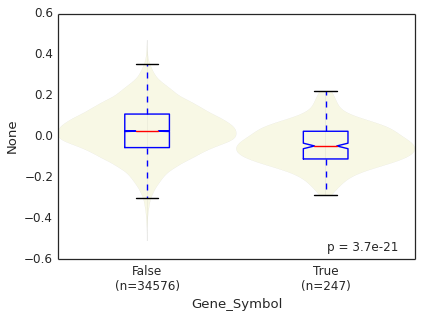

In [72]:
d = f_win.ix[ti(DX.probe_sets['Gene Body'] & (corr_with_exp < -.1))].dropna()

violin_plot_pandas(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION']>0)),
                   d)

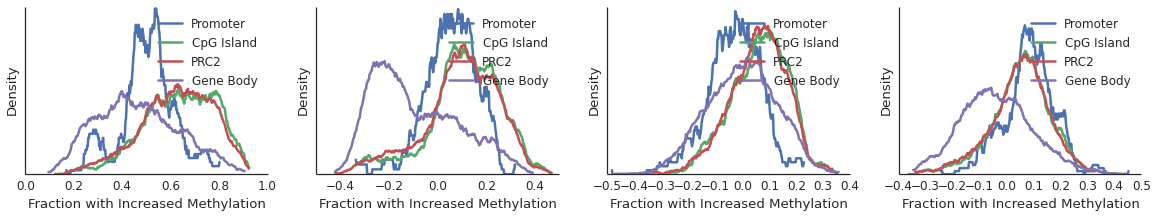

In [127]:
meth_plot(ti(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0))))

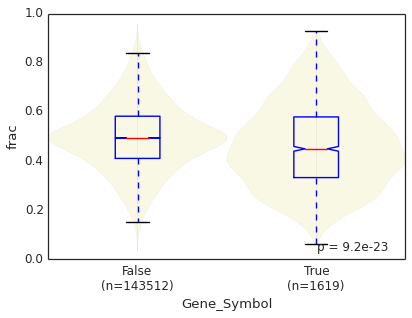

In [164]:
d = dx_meth.frac.ix[ti(DX.probe_sets['Gene Body'] )].dropna()
violin_plot_pandas(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)),
                   d)

In [171]:
len(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0))

272

In [193]:
dx_rna.ix[ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)].sort('p').head(10)

,num_ox,num_dx,frac,p
GABRD,607,684,0.89,4.59e-103
NPY5R,91,677,0.13,1.89e-89
PTH1R,98,684,0.14,1.46e-85
ADRA1A,107,683,0.16,1.48e-78
LEPR,115,684,0.17,4.40e-73
AVPR2,122,683,0.18,4.06e-68
GRIA1,123,676,0.18,5.91e-66
AGTR1,130,684,0.19,3.65e-63
GHR,130,684,0.19,3.65e-63
PTGER4,130,684,0.19,3.65e-63


In [202]:
dd = rna_df.ix['GABRD']
dd = (dd[:,'01'] - dd[:,'11']).dropna()
dx_s = dx.ix[ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0))]
rr = dx_s.T.corrwith(dd)
rr.name = 'corr'

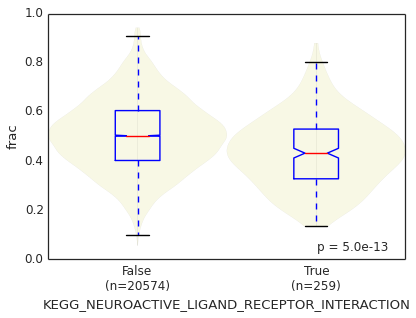

In [189]:
violin_plot_pandas(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0,
                   dx_rna.frac)

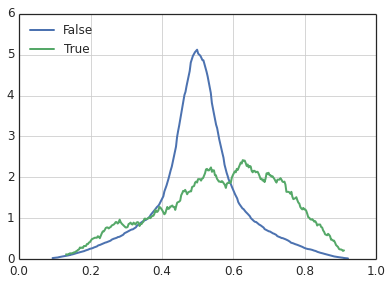

In [186]:
d = dx_meth.frac.ix[ti(DX.probe_sets['TSS'] )].dropna()
draw_dist(d, ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)))

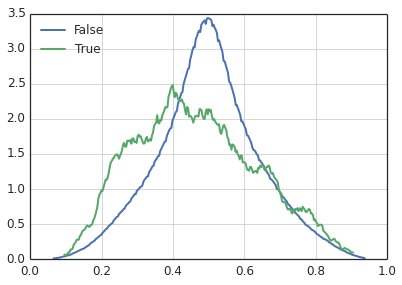

In [187]:
d = dx_meth.frac.ix[ti(DX.probe_sets['Gene Body'] )].dropna()
draw_dist(d, ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)))

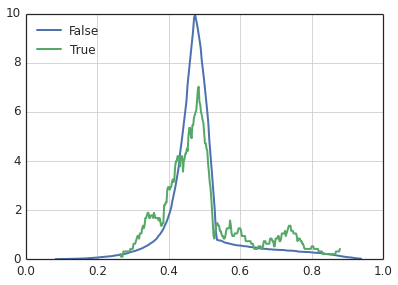

In [246]:
d = dx_meth.frac.ix[ti(DX.probe_sets['CpG Island'] & (disordered == False))].dropna()
draw_dist(d, ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)))

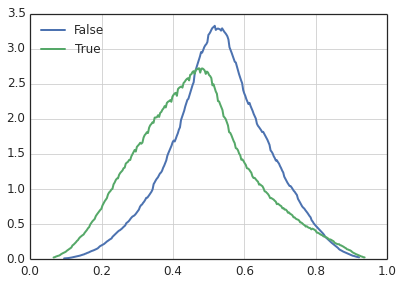

In [216]:
draw_dist(dx_meth.frac.ix[ti(corr_with_exp.abs() > .1)], 
          corr_with_exp > 0)

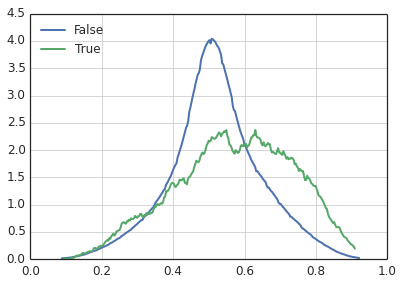

In [213]:
d = dx_meth.frac.ix[ti(corr_with_exp < 0)].dropna()
draw_dist(d, ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)))

In [254]:
d = dx_meth.frac.ix[ti(disordered == False)].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [255]:
r2.head()

,H,p,q
PID_RHOA_REG_PATHWAY,188.21,7.82e-43,1.04e-39
KEGG_ENDOCYTOSIS,158.99,1.88e-36,1.25e-33
KEGG_NOTCH_SIGNALING_PATHWAY,147.44,6.28e-34,2.78e-31
PID_MET_PATHWAY,139.76,3.00e-32,9.99e-30
REACTOME_TRANSLATION,137.63,8.77e-32,2.33e-29


In [251]:
d = f_win.ix[ti(disordered == False)].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [252]:
r2.head()

,H,p,q
PID_RHOA_REG_PATHWAY,166.61,4.08e-38,5.42e-35
PID_RAC1_REG_PATHWAY,116.55,3.61e-27,2.40e-24
REACTOME_TRANSLATION,109.61,1.19e-25,4.71e-23
BIOCARTA_GATA3_PATHWAY,109.27,1.42e-25,4.71e-23
BIOCARTA_AGPCR_PATHWAY,100.46,1.21e-23,3.21e-21


In [253]:
dx_rna.ix['RHOA']

num_ox    2.78e+02
num_dx    6.84e+02
frac      4.06e-01
p         1.12e-06
Name: RHOA, dtype: float64

In [247]:
d = f_win.ix[ti(DX.probe_sets['CpG Island'] & (disordered == False))].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [248]:
r2.head()

,H,p,q
BIOCARTA_CSK_PATHWAY,64.11,1.18e-15,1.57e-12
PID_AP1_PATHWAY,45.20,1.78e-11,1.18e-08
PID_ATF2_PATHWAY,44.38,2.70e-11,1.20e-08
BIOCARTA_AGPCR_PATHWAY,42.80,6.06e-11,2.02e-08
PID_RHOA_REG_PATHWAY,42.01,9.07e-11,2.41e-08


In [61]:
d = f_win.ix[ti(DX.probe_sets['CpG Island'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [62]:
r2.head()

,H,p,q
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,415.97,1.84e-92,2.44e-89
REACTOME_SIGNALING_BY_GPCR,315.73,1.23e-70,8.21e-68
NABA_MATRISOME,313.83,3.21e-70,1.42e-67
REACTOME_GPCR_DOWNSTREAM_SIGNALING,309.05,3.52e-69,1.17e-66
REACTOME_GPCR_LIGAND_BINDING,271.57,5.17e-61,1.38e-58


In [63]:
d = f_win.ix[ti(DX.probe_sets['Gene Body'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [73]:
r2.head()

,H,p,q
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,89.15,3.67e-21,4.88e-18
KEGG_GRAFT_VERSUS_HOST_DISEASE,86.58,1.34e-20,8.93e-18
KEGG_AUTOIMMUNE_THYROID_DISEASE,80.95,2.31e-19,1.03e-16
KEGG_ALLOGRAFT_REJECTION,80.03,3.68e-19,1.22e-16
REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION,78.79,6.92e-19,1.84e-16


In [74]:
d = pcna_corr.ix[ti(DX.probe_sets['TSS'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
#dd = dd.ix[ti(cc.abs() > .1)].dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [75]:
r2.head()

,H,p,q
REACTOME_OLFACTORY_SIGNALING_PATHWAY,738.23,1.46e-162,1.94e-159
KEGG_OLFACTORY_TRANSDUCTION,587.92,7.09e-130,4.72e-127
REACTOME_NEURONAL_SYSTEM,224.15,1.12e-50,4.98e-48
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,204.59,2.09e-46,6.93e-44
REACTOME_GPCR_LIGAND_BINDING,187.86,9.31e-43,2.48e-40


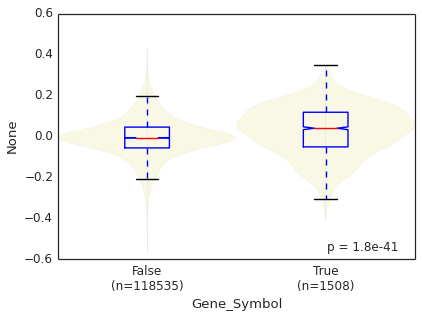

In [80]:
d = f_win.ix[ti(DX.probe_sets['TSS'])].dropna()

violin_plot_pandas(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)),
                   d)

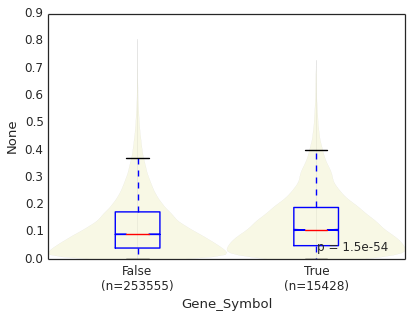

In [87]:
s = 'NABA_MATRISOME'
violin_plot_pandas(ann.Gene_Symbol.isin(ti(gene_sets[s]>0)),
                   corr_with_exp.abs())

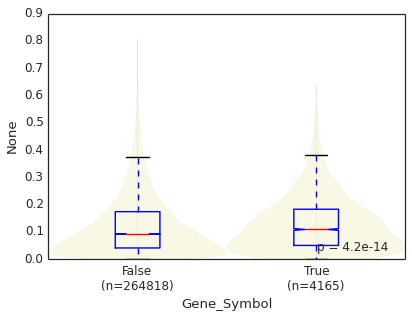

In [85]:
s = 'KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION'
violin_plot_pandas(ann.Gene_Symbol.isin(ti(gene_sets[s]>0)),
                   corr_with_exp.abs())

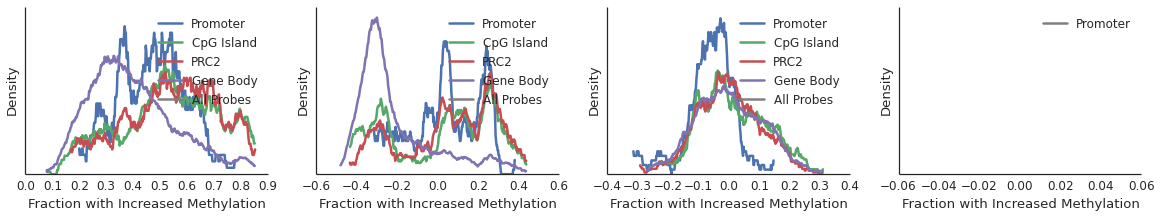

In [89]:
fig, axs= subplots(1,4, figsize=(20,3))
probes = ti(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_TYPE_I_DIABETES_MELLITUS']>0)))
for i,v in enumerate([dx_meth.frac, pcna_corr, f_win, pcna_win]):
    ax=axs[i]
    lw = 2.5
    v = v.ix[probes]
    draw_dist(v.ix[ti(DX.probe_sets['Promoter'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['CpG Island'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['PRC2'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['Gene Body'] & v)], ax=ax, lw=lw)
    draw_dist(pcna_corr.ix[ti(v)], ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','Gene Body', 'All Probes'))
    prettify_ax(ax)

In [427]:
def switch_plot(g):
    v = get_probe(g)
    v = logit_adj(v)
    v2 = pd.concat([standardize(v.ix[ti(codes==c)]) for c in codes.unique()])
    v2 = v2.clip(-5,5)
    fig, axs = subplots(1,2, figsize=(9,4))
    ax=axs[0]
    series_scatter(meta_pcna_all[:,'01'], v.ix[ti(codes=='KIRC')][:,'01'],
                   color=colors[1], ax=ax, ann=None)
    series_scatter(meta_pcna_all[:,'11'], v.ix[ti(codes=='KIRC')][:,'11'],
                   color=colors[0], ax=ax, ann=None)
    ax = axs[1]
    series_scatter(meta_pcna_all[:,'01'], v[:,'01'],
                   color=colors[1], ax=ax, ann=None, s=20, alpha=.3)
    series_scatter(meta_pcna_all[:,'11'], v[:,'11'],
                   color=colors[0], ax=ax, ann=None, s=20, alpha=.5)
    
    for ax in axs:
        prettify_ax(ax)
        ax.set_xbound(meta_pcna_all.min(), meta_pcna_all.max())
    fig.tight_layout()

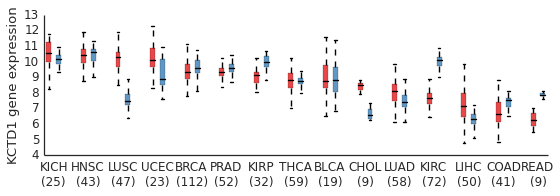

In [452]:
paired_bp_tn_split(rna_df.ix['KCTD1'], codes)

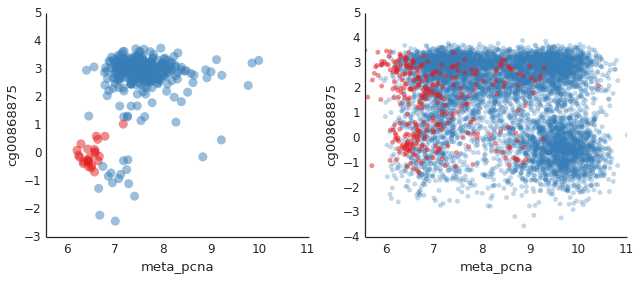

In [453]:
switch_plot('cg00868875')

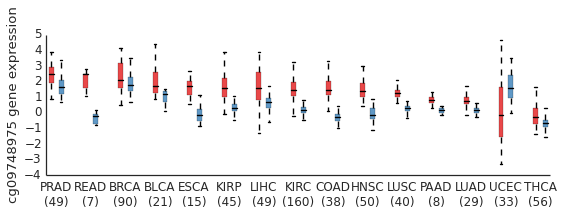

In [430]:
paired_bp_tn_split(logit_adj(matched_meth.ix['cg09748975']), codes)

In [431]:
f_win.order().head()

Hybridization REF
cg09571345          -0.56
cg15030449          -0.54
cg22016779          -0.53
cg23037321          -0.52
cg09701700          -0.52
dtype: float64

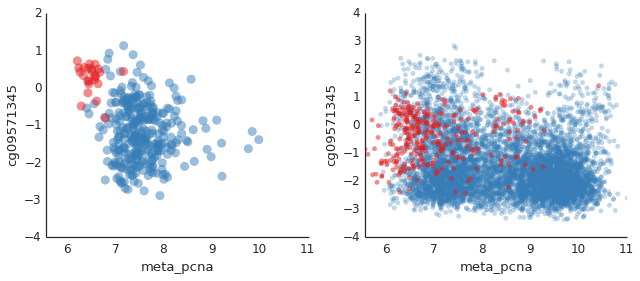

In [432]:
switch_plot('cg09571345')

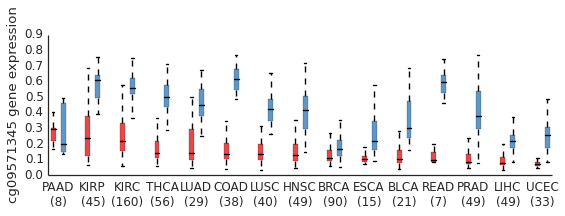

In [433]:
paired_bp_tn_split(matched_meth.ix['cg09571345'], codes)

In [106]:
dx_meth.frac.order().head()

Hybridization REF
cg10216717           0.03
cg27166177           0.04
cg17811434           0.04
cg18222913           0.04
cg18451817           0.04
Name: frac, dtype: float64

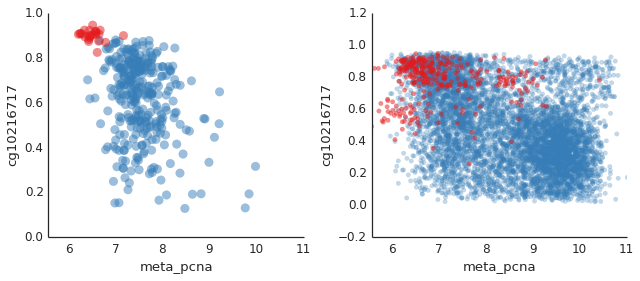

In [107]:
switch_plot('cg10216717')

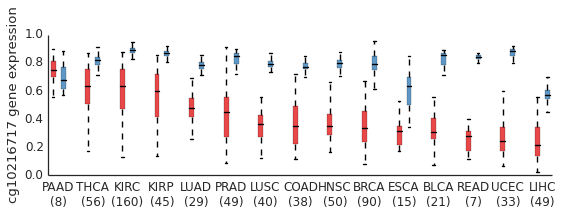

In [108]:
paired_bp_tn_split(matched_meth.ix['cg10216717'], codes)

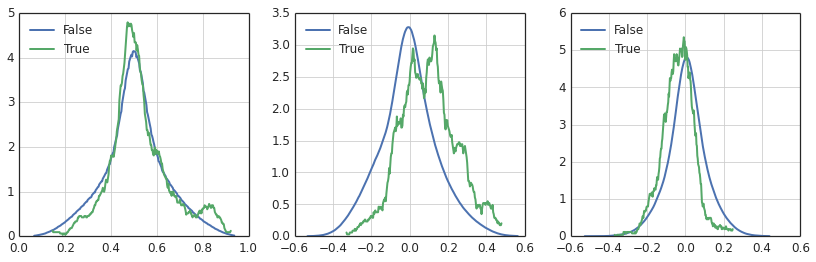

In [249]:
fig, axs = subplots(1,3, figsize=(14,4))
draw_dist(dx_meth.frac, ann.Gene_Symbol.str.startswith('HIST').dropna(), ax=axs[0])
draw_dist(pcna_corr, ann.Gene_Symbol.str.startswith('HIST').dropna(), ax=axs[1])
draw_dist(f_win, ann.Gene_Symbol.str.startswith('HIST').dropna(), ax=axs[2])

In [252]:
d = f_win.ix[ti(DX.probe_sets['Gene Body'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna().join(dx_rna.frac, on='Gene_Symbol')
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [253]:
r2.head()

,H,p,q
NABA_MATRISOME,137.17,1.10e-31,1.47e-28
PID_SYNDECAN_1_PATHWAY,120.62,4.62e-28,3.07e-25
PID_INTEGRIN1_PATHWAY,117.14,2.67e-27,1.19e-24
REACTOME_COLLAGEN_FORMATION,109.38,1.34e-25,3.65e-23
NABA_CORE_MATRISOME,109.22,1.45e-25,3.65e-23


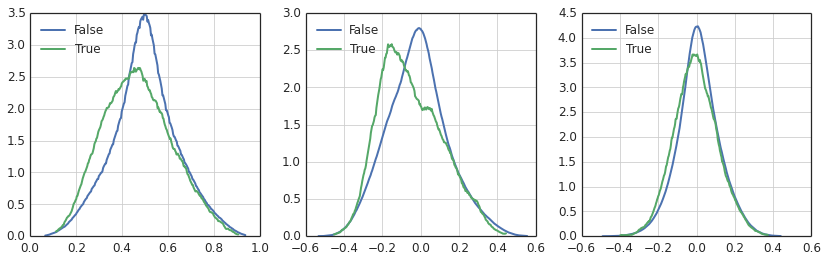

In [256]:
fig, axs = subplots(1,3, figsize=(14,4))
v = ann.Gene_Symbol.isin(ti(gs2['NABA_MATRISOME']>0)).dropna()
v = v.ix[ti(DX.probe_sets['Gene Body'])].dropna()
draw_dist(dx_meth.frac, v, ax=axs[0])
draw_dist(pcna_corr, v, ax=axs[1])
draw_dist(f_win, v, ax=axs[2])

In [263]:
d = f_win.ix[ti(DX.probe_sets['CpG Island'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna().join(dx_rna.frac, on='Gene_Symbol')
vec = dd.set_index('Gene_Symbol')['d']

In [260]:
gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [261]:
r2.head()

,H,p,q
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,211.04,8.13e-48,1.08e-44
REACTOME_SIGNALING_BY_GPCR,138.34,6.13e-32,4.07e-29
REACTOME_GPCR_DOWNSTREAM_SIGNALING,133.15,8.39e-31,3.72e-28
NABA_CORE_MATRISOME,110.81,6.51e-26,2.17e-23
REACTOME_NEURONAL_SYSTEM,103.62,2.44e-24,6.50e-22


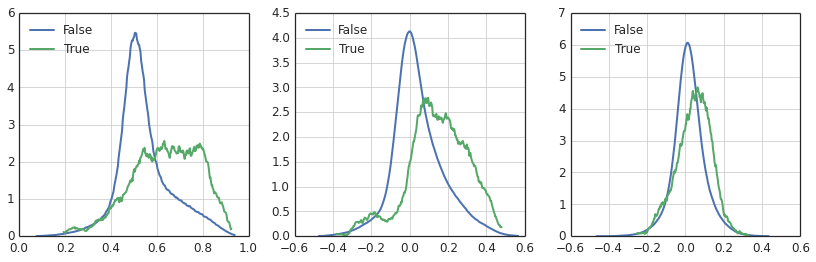

In [262]:
fig, axs = subplots(1,3, figsize=(14,4))
v = ann.Gene_Symbol.isin(ti(gs2['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)).dropna()
v = v.ix[ti(DX.probe_sets['CpG Island'])].dropna()
draw_dist(dx_meth.frac, v, ax=axs[0])
draw_dist(pcna_corr, v, ax=axs[1])
draw_dist(f_win, v, ax=axs[2])

In [264]:
d = f_win.ix[ti(DX.probe_sets['Promoter'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna().join(dx_rna.frac, on='Gene_Symbol')
vec = dd.set_index('Gene_Symbol')['d']

In [265]:
gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [266]:
r2.head()

,H,p,q
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,76.93,1.77e-18,2.36e-15
KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS,74.90,4.96e-18,3.30e-15
KEGG_ALLOGRAFT_REJECTION,67.60,2.00e-16,6.86e-14
KEGG_TYPE_I_DIABETES_MELLITUS,67.54,2.06e-16,6.86e-14
KEGG_CELL_ADHESION_MOLECULES_CAMS,66.63,3.27e-16,8.69e-14


In [457]:
v1 = dd['d']
g1 = dd['Gene_Symbol']

In [464]:
v1.groupby(g1).mean().ix[ti(g1.value_counts() > 4)].order()

ICAM1            -0.29
MAFK             -0.23
MT1DP            -0.22
ZNF586           -0.22
IFFO1            -0.21
TRIM59           -0.20
CCND1            -0.20
LOC387647        -0.20
GLIPR1L2         -0.20
DKFZp686O24166   -0.20
AMN1             -0.20
ABLIM3           -0.19
TES              -0.19
LYPLAL1          -0.18
SPAG5            -0.18
...
KCTD1       0.20
C4orf44     0.20
SLC2A5      0.21
TCF15       0.21
DPP10       0.21
KCNAB3      0.22
MMRN2       0.22
TMPRSS12    0.23
STX11       0.24
AURKC       0.24
UCN         0.27
MAP3K11     0.27
TAF7L       0.28
ALPK1       0.30
REC8        0.35
Length: 3043, dtype: float64

In [153]:
gg = ti(gs2['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)

In [154]:
by_gene = pd.DataFrame({g: anova(g1 == g, v1) for g in gg}).T

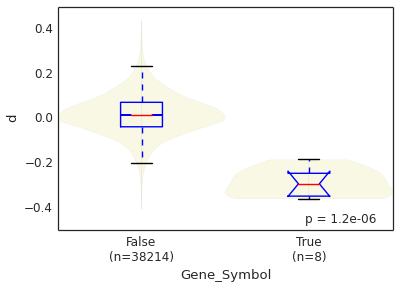

In [465]:
violin_plot_pandas(g1 == 'ICAM1', v1)

In [155]:
by_gene.sort('p').head(20)

,F,p
DRD4,51.06,9.03e-13
PRLHR,33.71,6.42e-09
EDNRB,32.28,1.34e-08
KISS1R,29.83,4.74e-08
HTR6,27.70,1.42e-07
DRD5,22.96,1.66e-06
OXTR,21.31,3.91e-06
P2RY2,19.59,9.62e-06
GABBR2,17.97,2.24e-05
ADRB1,15.01,1.07e-04


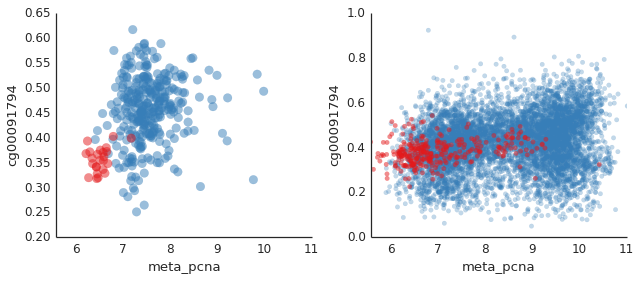

In [161]:
switch_plot('cg00091794')

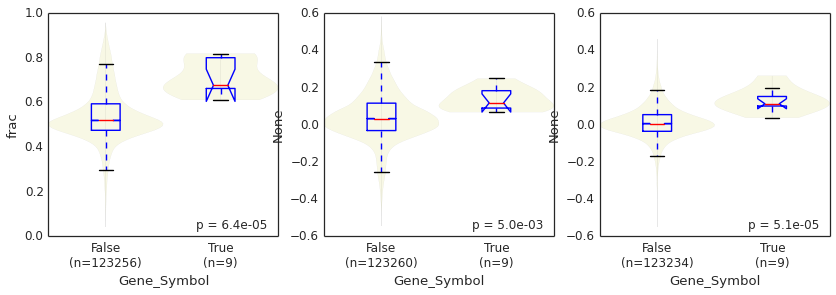

In [43]:
fig, axs = subplots(1,3, figsize=(14,4))
v = ann.Gene_Symbol == 'GABBR2'
v = v.ix[ti(DX.probe_sets['CpG Island'])].dropna()
violin_plot_pandas(v, dx_meth.frac, ax=axs[0])
violin_plot_pandas(v, pcna_corr, ax=axs[1])
violin_plot_pandas(v, f_win, ax=axs[2])

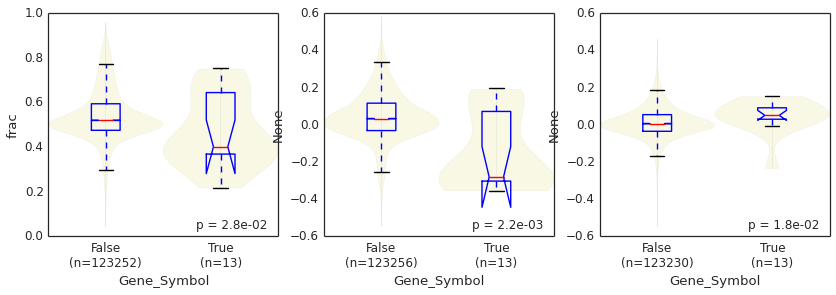

In [44]:
fig, axs = subplots(1,3, figsize=(14,4))
v = ann.Gene_Symbol == 'GABRD'
v = v.ix[ti(DX.probe_sets['CpG Island'])].dropna()
violin_plot_pandas(v, dx_meth.frac, ax=axs[0])
violin_plot_pandas(v, pcna_corr, ax=axs[1])
violin_plot_pandas(v, f_win, ax=axs[2])

In [45]:
d = dx_meth.frac.ix[ti(DX.probe_sets['CpG Island'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna().join(dx_rna.frac, on='Gene_Symbol')
vec = dd.set_index('Gene_Symbol')['d']

In [46]:
gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [47]:
r2.head()

,H,p,q
REACTOME_GPCR_LIGAND_BINDING,769.10,2.82e-169,3.75e-166
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,760.60,1.99e-167,1.32e-164
REACTOME_GPCR_DOWNSTREAM_SIGNALING,696.12,2.09e-153,9.27e-151
REACTOME_SIGNALING_BY_GPCR,685.54,4.17e-151,1.39e-148
REACTOME_CLASS_A1_RHODOPSIN_LIKE_RECEPTORS,593.00,5.58e-131,1.48e-128


In [59]:
d = f_win.ix[ti(DX.probe_sets['CpG Island'])].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna().join(dx_rna.frac, on='Gene_Symbol')
vec = dd.set_index('Gene_Symbol')['d']

In [60]:
gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [61]:
r2.head()

,H,p,q
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,299.88,3.50e-67,4.66e-64
REACTOME_SIGNALING_BY_GPCR,203.08,4.44e-46,2.95e-43
REACTOME_GPCR_DOWNSTREAM_SIGNALING,191.14,1.79e-43,7.93e-41
NABA_MATRISOME,173.73,1.13e-39,3.77e-37
REACTOME_NEURONAL_SYSTEM,151.89,6.70e-35,1.78e-32


In [48]:
v = gs2['REACTOME_GPCR_LIGAND_BINDING']

In [62]:
v = ann.Gene_Symbol.isin(ti(gene_sets['NABA_MATRISOME']>0))

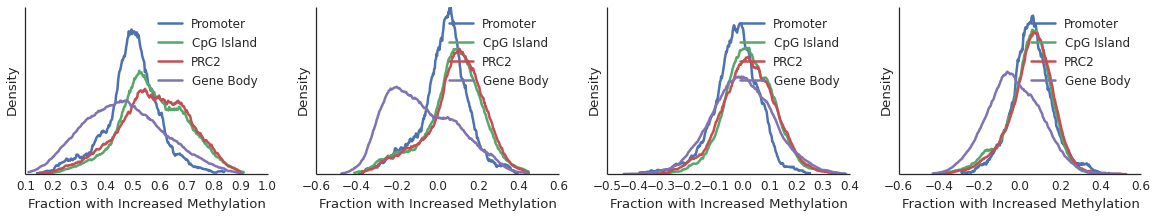

In [113]:
fig, axs= subplots(1,4, figsize=(20,3))
probes = ti(ann.Gene_Symbol.isin(ti(gene_sets['NABA_MATRISOME']>0)))
for i,v in enumerate([dx_meth.frac, pcna_corr, f_win, pcna_win]):
    ax=axs[i]
    lw = 2.5
    v = v.ix[probes]
    draw_dist(v.ix[ti(DX.probe_sets['Promoter'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['CpG Island'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['PRC2'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['Gene Body'] & v)], ax=ax, lw=lw)
    #draw_dist(pcna_corr.ix[ti(v)], ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','Gene Body', 'All Probes'))
    prettify_ax(ax)

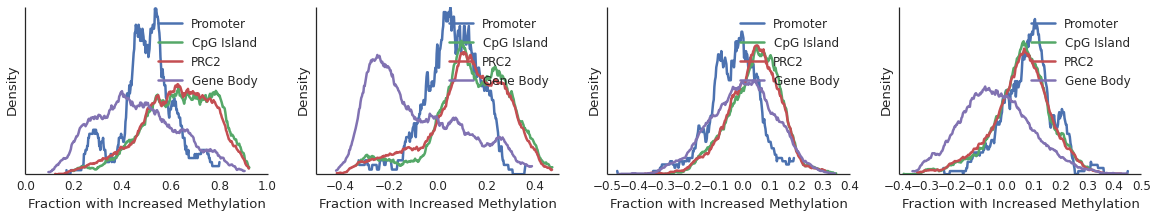

In [112]:
fig, axs= subplots(1,4, figsize=(20,3))
probes = ti(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0)))
for i,v in enumerate([dx_meth.frac, pcna_corr, f_win, pcna_win]):
    ax=axs[i]
    lw = 2.5
    v = v.ix[probes]
    draw_dist(v.ix[ti(DX.probe_sets['Promoter'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['CpG Island'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['PRC2'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['Gene Body'] & v)], ax=ax, lw=lw)
    #draw_dist(pcna_corr.ix[ti(v)], ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','Gene Body', 'All Probes'))
    prettify_ax(ax)

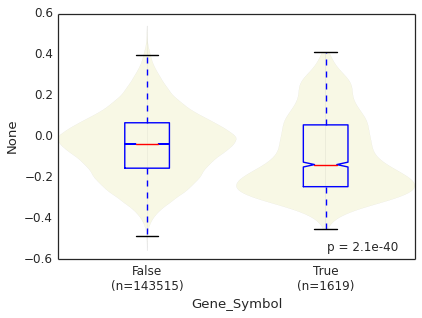

In [72]:
probes = ann.Gene_Symbol.isin(ti(gene_sets['KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION']>0))
violin_plot_pandas(probes.ix[ti(DX.probe_sets['Gene Body'])], pcna_corr)

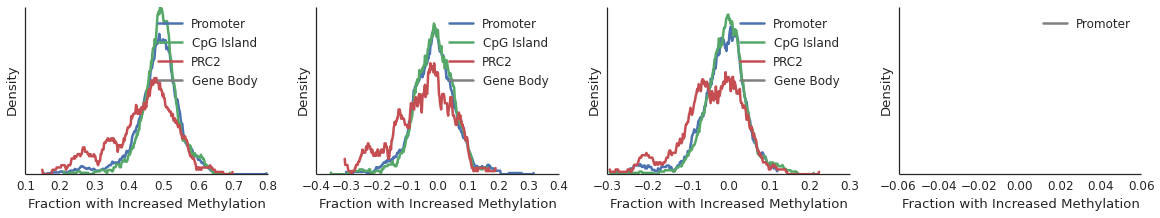

In [107]:
fig, axs= subplots(1,4, figsize=(20,3))
probes = ti(ann.Gene_Symbol.isin(ti(gene_sets['KEGG_RIBOSOME']>0)))
for i,v in enumerate([dx_meth.frac, pcna_corr, f_win, pcna_win]):
    ax=axs[i]
    lw = 2.5
    v = v.ix[probes]
    draw_dist(v.ix[ti(DX.probe_sets['Promoter'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['CpG Island'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['PRC2'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['Gene Body'] & v)], ax=ax, lw=lw)
    draw_dist(pcna_corr.ix[ti(v)], ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','Gene Body', 'All Probes'))
    prettify_ax(ax)

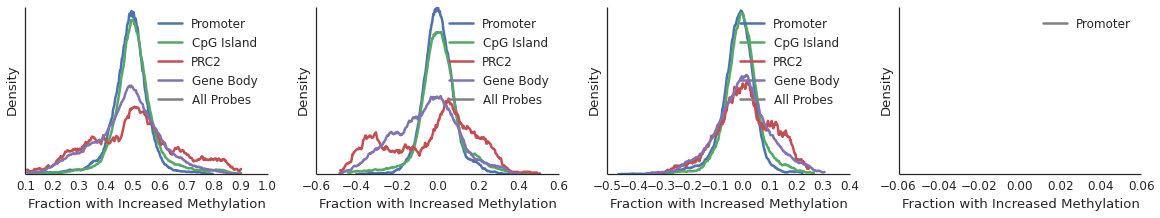

In [84]:
fig, axs= subplots(1,4, figsize=(20,3))
probes = ti(ann.Gene_Symbol.isin(ti(gene_sets['REACTOME_METABOLISM_OF_PROTEINS']>0)))
for i,v in enumerate([dx_meth.frac, pcna_corr, f_win, pcna_win]):
    ax=axs[i]
    lw = 2.5
    v = v.ix[probes]
    draw_dist(v.ix[ti(DX.probe_sets['Promoter'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['CpG Island'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['PRC2'] & v)], ax=ax, lw=lw)
    draw_dist(v.ix[ti(DX.probe_sets['Gene Body'] & v)], ax=ax, lw=lw)
    draw_dist(pcna_corr.ix[ti(v)], ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','Gene Body', 'All Probes'))
    prettify_ax(ax)